# Artificial Neural Networks and Deep Learning


---


# Homework 1 - Data wrangling


## ⚙️ Import Libraries

In [151]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

## 🗺️ Data exploration 

In [152]:
# Load Data
data = np.load('training_set.npz')

x = data['images']
y = data['labels']

np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=uint8),
 array([1052, 2381, 1285, 2226, 1049, 1393, 2530, 1843], dtype=int64))

In [153]:
x.shape

(13759, 96, 96, 3)

In [154]:
# Labels dictionary
labels_dict = {
    0: 'Basophil',
    1: 'Eosinophil',
    2: 'Erythroblast',
    3: 'Immature granulocytes',
    4: 'Lymphocyte',
    5: 'Monocyte',
    6: 'Neutrophil',
    7: 'Platelet'
}

In [155]:
class_count = {}
for i in labels_dict:
    class_count[i] = np.unique(y, return_counts=True)[1][i]

class_count

{0: 1052, 1: 2381, 2: 1285, 3: 2226, 4: 1049, 5: 1393, 6: 2530, 7: 1843}

In [156]:
# see image augmentation section to fix unbalanced classes

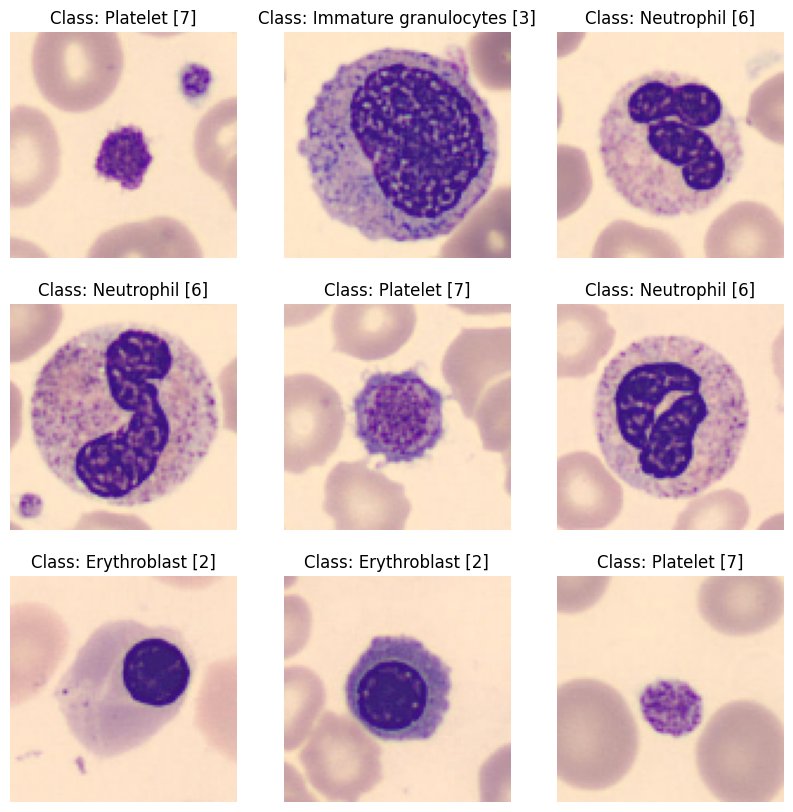

In [157]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.reshape((-1,))
for i in range(9):
    axs[i].imshow(x[i])
    axs[i].set_title(f'Class: {labels_dict[y[i][0]]} {y[i]}')
    axs[i].axis('off')

In [158]:
# todo: show meme sample (when you find one)

## 🧹 Data Cleaning

In [159]:
# reshape x to apply PCA
x_flat = x.reshape(x.shape[0], -1)

# Reduce dimensions to 2 to plot data
pca = PCA(n_components=2)
features_pca = pca.fit_transform(x_flat)

In [160]:
pca.components_.shape

(2, 27648)

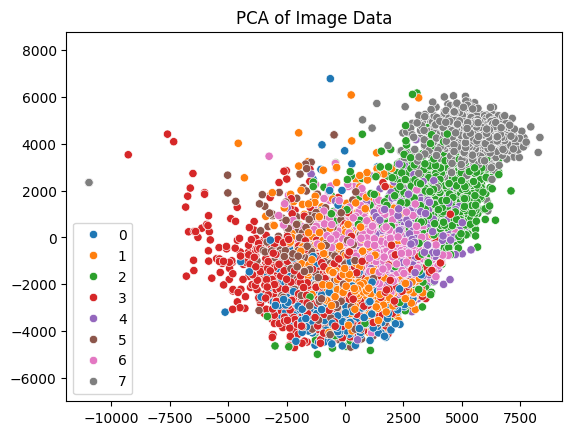

In [161]:
# Plot Principal components
plt.title('PCA of Image Data')
plt.axis('equal')
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=y.flatten(),palette='tab10')
plt.show()

The points that are further away are outliers, so now let's find them

In [162]:
# Calculate euclidian distance from each sample to the origin in the PCA space
distances = np.linalg.norm(features_pca, axis=1)

# Let's find the 20 samples that are further away from the origin
num_outliers = 20
outlier_indices = np.argsort(distances)[-num_outliers:]
outlier_indices

array([12682, 12681, 12680, 12679, 12678, 12677, 12664, 12676, 12674,
       12673, 12672, 12671, 12670, 12669, 12668, 12667, 12666, 12675,
       12854, 12776], dtype=int64)

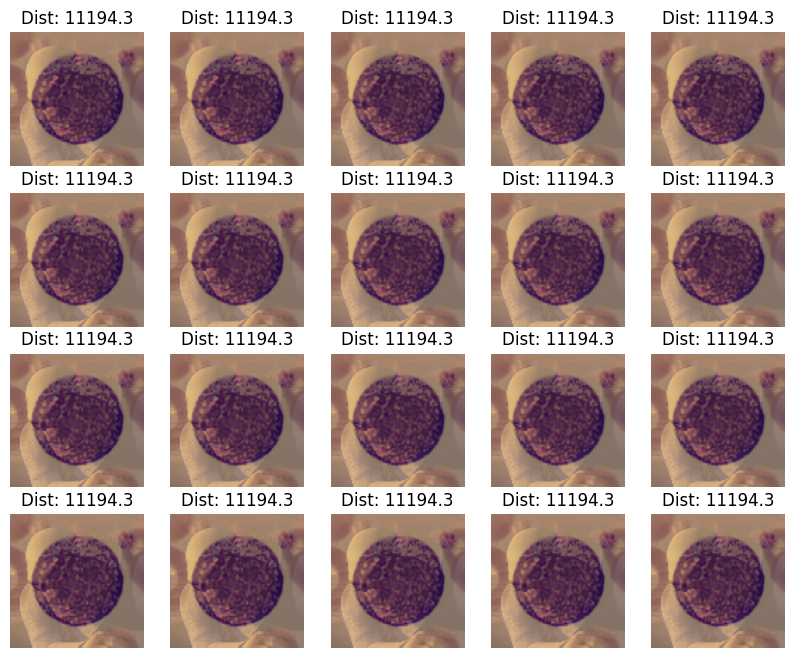

In [163]:
# show some of these outliers
fig, axs = plt.subplots(4, 5, figsize=(10, 8))
axs = axs.reshape((-1,))
for i,idx in enumerate(outlier_indices):
    axs[i].imshow(x[idx])
    axs[i].axis('off')
    axs[i].set_title(f'Dist: {round(distances[idx], 1)}')

### 🧐 🧐 🧐 🧐 This all seem to be shrek images merged with cell images

Luckily it seems that all of these Shreks are positioned at the same distance from the origin. This makes it easier to identify them.

In [164]:
print("Distances of the outliers:", distances[outlier_indices])
sherk_distance = round(distances[outlier_indices][-1])
sherk_distance

Distances of the outliers: [11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185
 11194.34709185 11194.34709185 11194.34709185 11194.34709185]


11194

In [143]:
# Identify the samples which distance is less than the outlier distance
close_indices = np.where(distances < sherk_distance)[0]
distances = distances[close_indices]

print("Number of trash samples:")
print(x.shape[0] - close_indices.shape[0])

Number of trash samples:
1600


In [144]:
close_indices.shape

(12159,)

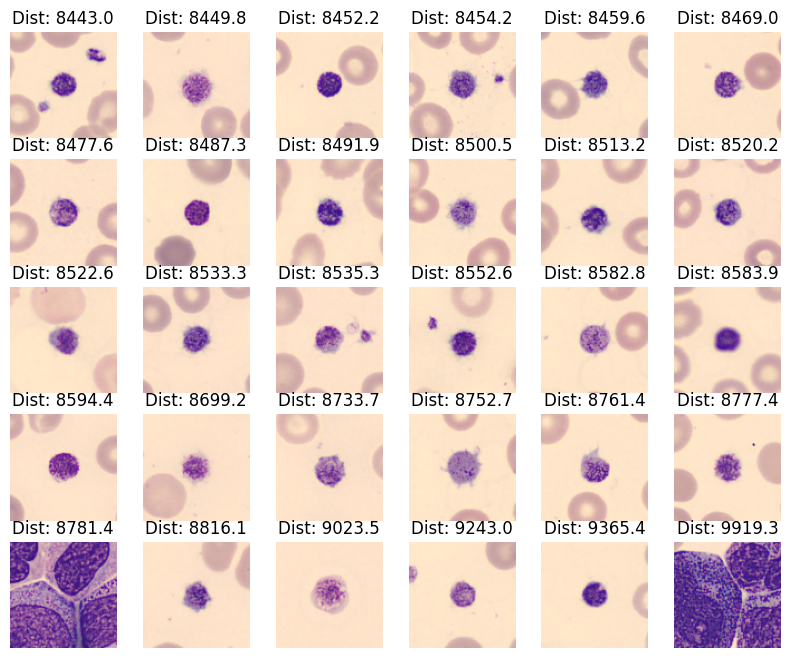

In [145]:
# see new further away samples
num_outliers = 30
outlier_indices = np.argsort(distances)[-num_outliers:]

# show some of these outliers
fig, axs = plt.subplots(5, 6, figsize=(10, 8))
axs = axs.reshape((-1,))
for i,idx in enumerate(outlier_indices):
    axs[i].imshow(x[idx])
    axs[i].axis('off')
    axs[i].set_title(f'Dist: {round(distances[idx], 1)}')

In [146]:
# keep only the clean samples from x and y
x_clean = x[close_indices]
y_clean = y[close_indices]

This data seems ok, however by pure mistake (I got rickrolled) I found another meme inside the data, and this one is not as far as the other one...
Let's see if I can map the distance and find if there are more of these

Text(0.5, 1.0, 'Dist: 4411.4')

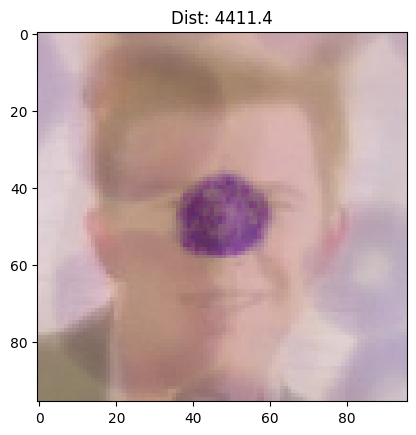

In [182]:
plt.imshow(x[-1])
plt.title(f'Dist: {round(distances[-1], 1)}')

In [148]:
rick_distance = round(distances[-1])
ricks = np.where((distances > rick_distance) & (distances < rick_distance+1))[0]
ricks.shape

(200,)

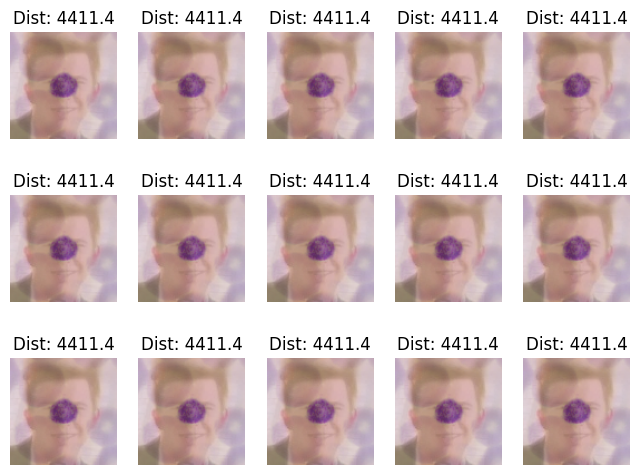

In [149]:
#select 10 random samples from the ricks
rick_indices = np.random.choice(ricks, 15)
# show some of these ricks
fig, axs = plt.subplots(3, 5, figsize=(8, 6))
axs = axs.reshape((-1,))
for i,idx in enumerate(rick_indices):
    axs[i].imshow(x_clean[idx])
    axs[i].axis('off')
    axs[i].set_title(f'Dist: {round(distances[idx], 1)}')

200 more trash samples...

In [150]:
# Delete the ricks
x_clean = np.delete(x_clean, rick_indices, axis=0)
y_clean = np.delete(y_clean, rick_indices, axis=0)
distances = np.delete(distances, rick_indices, axis=0)

x_clean.shape, y_clean.shape, distances.shape

((12144, 96, 96, 3), (12144, 1), (12144,))

In [ ]:
# Normalize data to the range [0, 1]
x = (x / 255).astype('float32')

## ➕ Image Augmentation

In [ ]:
print(labels_dict)
np.unique(y, return_counts=True)

class `6: 'Neutrophil'` has the most images with 2530 samples. Have to augment to level all other classes to this one

In [ ]:
# Define a sequential model for image augmentation
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    # Let's try not to change the image, just move it^
    # tfkl.RandomBrightness(0.5, value_range=(0,1)),
    # tfkl.RandomContrast(0.75),
], name='Augmentation')

# Set up the figure and grid layout for displaying images
fig, axs = plt.subplots(1, 4, figsize=(10, 10))

img = x[0] # Select the first image from the dataset for example

# Display the original image
axs[0].imshow(img)
axs[0].axis('off')
axs[0].set_title('Original Image')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[1].imshow(augmented_img)
axs[1].axis('off')
axs[1].set_title('Augmented Image 1')

# Apply augmentation and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[2].imshow(augmented_img)
axs[2].axis('off')
axs[2].set_title('Augmented Image 2')

# Apply augmentation and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
axs[3].imshow(augmented_img)
axs[3].axis('off')
axs[3].set_title('Augmented Image 3')

plt.show()

This is the augmentation layer that will be used for all classes to reach 2600 samples

In [ ]:
new_x = []
new_y = []
# Sweep for every class
for clas in class_count:
    print(f'Augmenting class {clas}...')
    # Filter images of current class
    class_images = x[y.flatten() == clas]
    
    while class_count[clas] < 2600:
        # Select a random image from the current class
        random_index = np.random.randint(0, class_images.shape[0])
        original_img = class_images[random_index]
        
        # Apply augmentation layer
        augmented_img = np.clip(augmentation(original_img), 0., 1.)
        
        # Add new image and its label to data
        new_x.append(augmented_img)
        new_y.append(clas)
        
        class_count[clas] += 1

# Concatenate the augmented data into the whole data
new_x = np.array(new_x)
new_y = np.array(new_y).reshape(-1, 1)

x = np.concatenate([x, new_x], axis=0)
y = np.concatenate([y, new_y], axis=0)


In [ ]:
np.unique(y, return_counts=True)

## 💾 Save clean data